# Imports and Data Preparation

Comparisions for RF-GAP
    - MALI
    - KEMA (MAT-LAB); wait


Some Ideas:
- Since this method requires labels, we could classiy different domains based on the labels. For example, if we have a data set of people sick with Creutzfeld-Jakob discease and the other domain is people who are sick with alzheimers. 

In [26]:
from MASH import MASH
import numpy as np
import pandas as pd
import test_manifold_algorithms as tma
from SPUD import SPUD
from rfgap import RFGAP
import matplotlib.pyplot as plt


#DC is short for data class
dc = tma.test_manifold_algorithms(csv_file="iris.csv", split = "distort", percent_of_anchors= [0.2], verbose = 2, random_state= 10)


 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

MDS initialized with 4 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [4]:
#Create a normalize function
def normalize_0_to_1(value):
    """Normalizes the value to be between 0 and 1 and resets infinite values and converts to Distance"""

    #Scale it and check to ensure no devision by 0
    if np.max(value[~np.isinf(value)]) != 0:

      value = (value - value.min()) / (value[~np.isinf(value)].max() - value.min()) 

    #Reset inf values
    value[np.isinf(value)] = 1

    return 1 - value

In [5]:
#Create a normalize function
def normalize_outliers(value):
    """Normalizes the value to be between 0 and 1 and resets infinite values."""

    value = np.array(value)

    #Scale it and check to ensure no devision by 0
    if np.max(value[~np.isinf(value)]) != 0:
      
      #Reduce outliers
      percentile = np.percentile(value, 75)

      #Reset the values to be the percentile
      value[value > percentile] = percentile

      value = (value - value.min()) / (value[~np.isinf(value)].max() - value.min()) 

    return 1- np.array(value)

In [6]:
#Create an RF Proximities function
def use_rf_proximities(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=dc.labels, prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        if hasattr(self, "known_anchors_adjusted"):
            self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

# Applying RF GAP for SPUD

In [5]:
#Initialize SPUD Class
spud_class = SPUD(distance_measure_A = use_rf_proximities, distance_measure_B= use_rf_proximities, knn = 12, agg_method = "log", OD_method="abs", adj_block=True, similarity_measure="NAMA", verbose = 3)

#Fit SPUD
spud_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:4])

Skipping graph creating. Performing nearest anchor manifold alignment (NAMA) instead of SPUD.
Preforming abs calculations.

Adjusting self.distsA and self.distsB to reflect the similaritiy measure adjustment.
<><><><><><><><><><><><><>  Processed Finished  <><><><><><><><><><><><><>


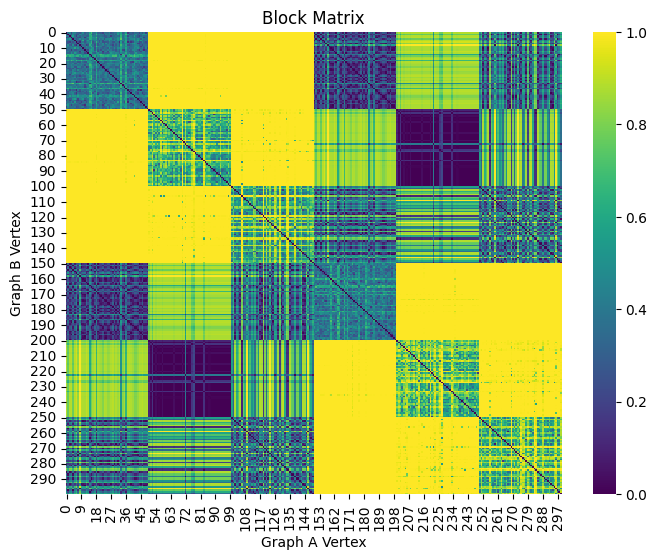

In [29]:
spud_class.plot_heat_map()

Cross Embedding: 0.9733333333333334
FOSCTTM: 0.023866666666666668


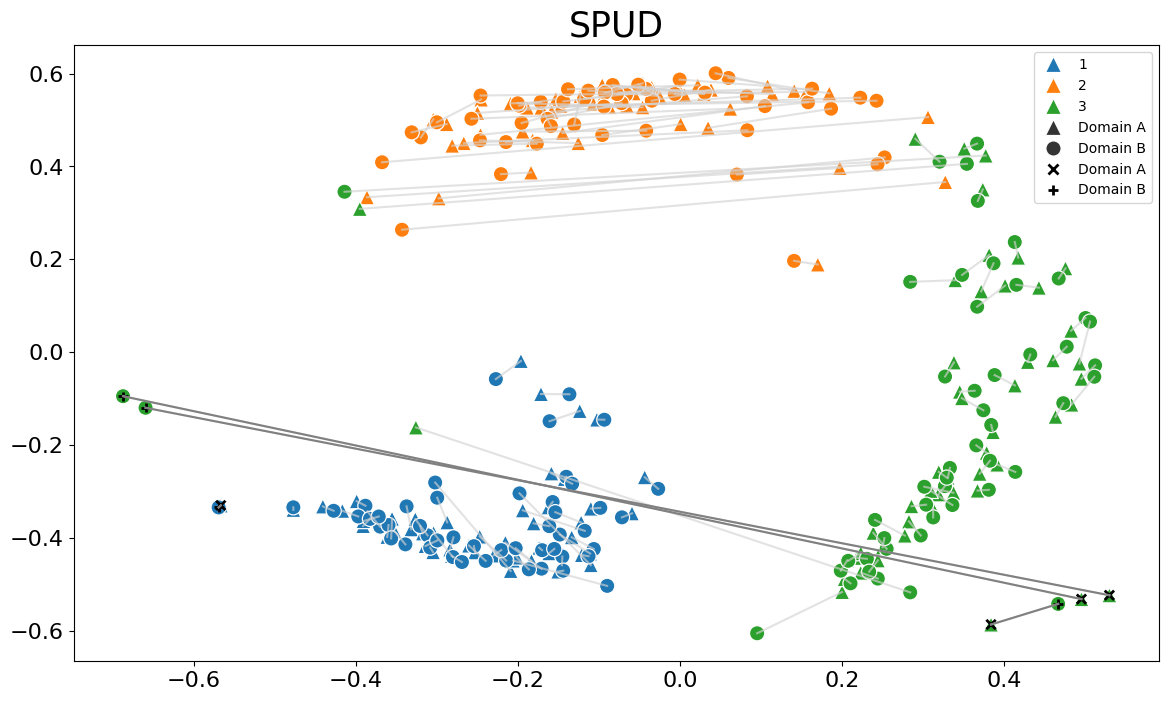

In [30]:
spud_class.plot_emb(labels = dc.labels_doubled, show_lines = True, show_anchors = True)

# Applying RF GAP for MASH

In [16]:
#Create an RF Proximities function
def use_rf_proximities_MASH(self, tuple):
    """Creates RF proximities similarities
    
        tuple should be a tuple with position 0 being the data and position 1 being the labels"""
    #Initilize Class
    rf_class = RFGAP(prediction_type="classification", y=tuple[1], prox_method="rfgap", matrix_type= "dense", triangular=False, non_zero_diagonal=True)

    #Fit it for Data A
    rf_class.fit(tuple[0], y = tuple[1])

    #Get promities
    dataA = rf_class.get_proximities()

    #Reset len_A and other varables
    if self.len_A == 2:
        self.len_A = len(tuple[0]) 

        #Change known_anchors to correspond to off diagonal matricies -- We have to change this as its dependent upon A
        if hasattr(self, "known_anchors_adjusted"):
            self.known_anchors_adjusted = np.vstack([self.known_anchors.T[0], self.known_anchors.T[1] + self.len_A]).T

    elif self.len_B == 2:
        self.len_B = len(tuple[0])

    #Scale it and check to ensure no devision by 0
    if np.max(dataA[~np.isinf(dataA)]) != 0:

      dataA = (dataA - dataA.min()) / (dataA[~np.isinf(dataA)].max() - dataA.min()) 

    #Reset inf values
    dataA[np.isinf(dataA)] = 1

    return 1 - dataA

In [17]:
#Initialize SPUD Class
mash_class = MASH(distance_measure_A = use_rf_proximities_MASH, distance_measure_B= use_rf_proximities_MASH, knn = 35, verbose = 3, DTM = "hellinger")

#Fit SPUD
mash_class.fit(dataA = (dc.split_A, dc.labels), dataB = (dc.split_B, dc.labels), known_anchors = dc.anchors[:4])

Using optimal t value of 36


Cross Embedding: 0.98
FOSCTTM: 0.13697777777777778


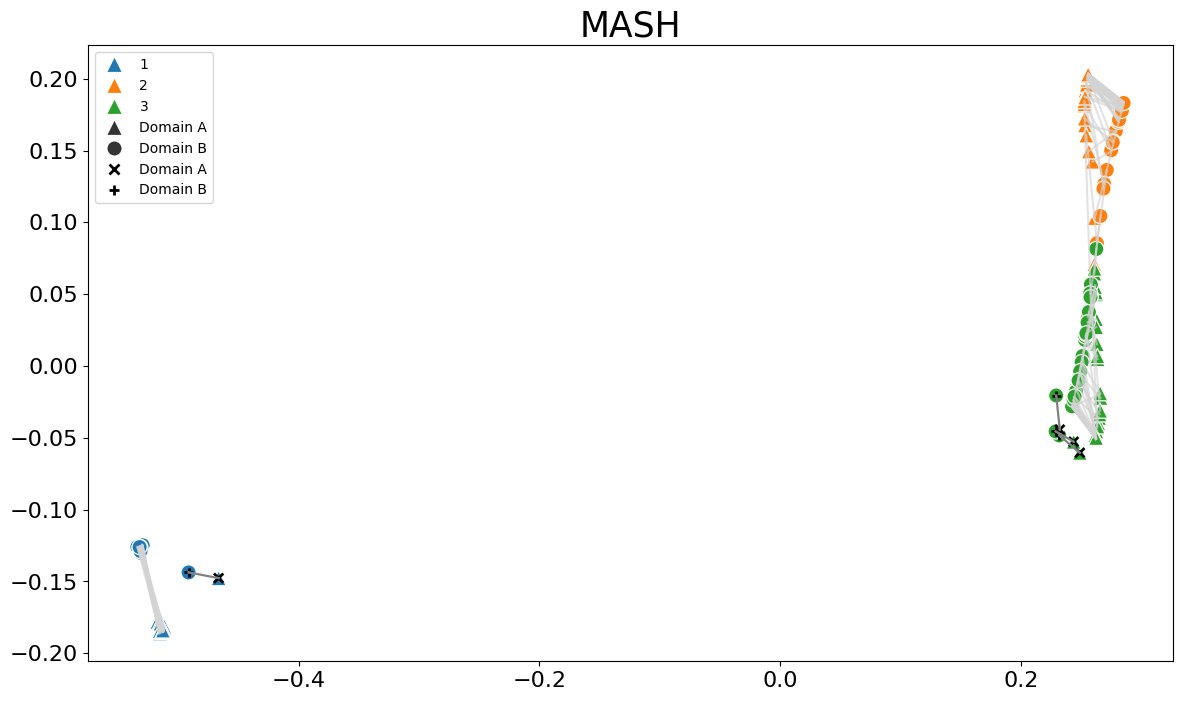

In [18]:
mash_class.plot_emb(labels = dc.labels_doubled)

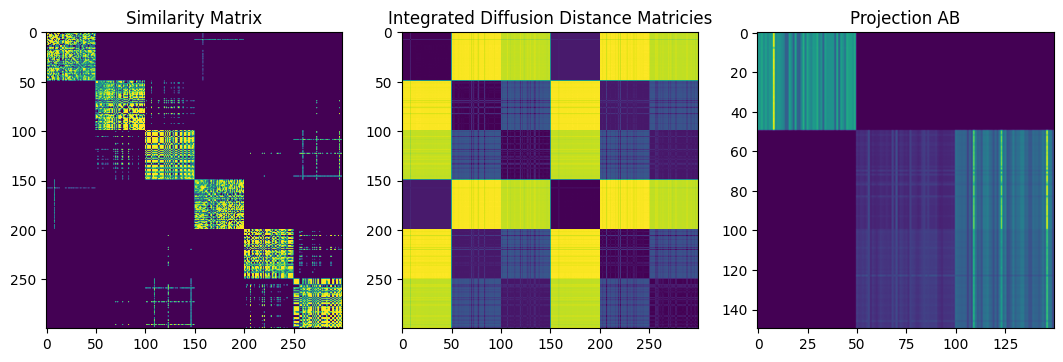

In [19]:
mash_class.plot_heat_maps()

Using optimal t value of 38


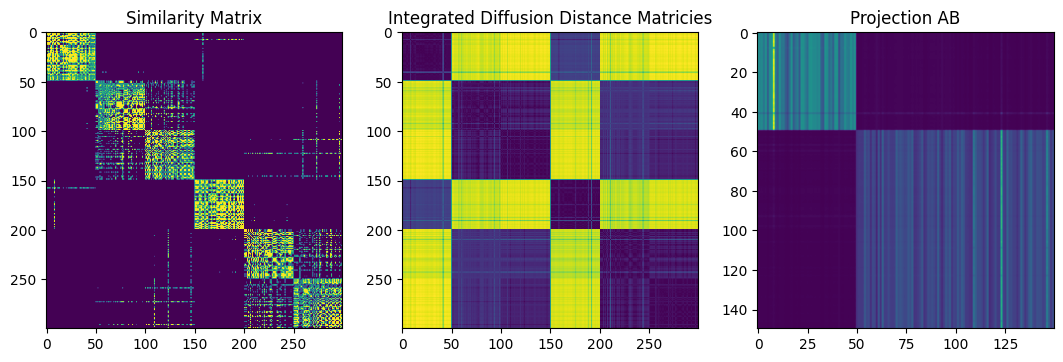

In [27]:
#Initialize SPUD Class
mash_class2 = MASH(knn = 35, verbose = 3, DTM = "log")
mash_class2.fit(dataA = dc.split_A, dataB = dc.split_B, known_anchors = dc.anchors[:4])
mash_class2.plot_heat_maps()

In [ ]:
mash_class2.plot_emb(labels = dc.labels)

<><><><><> Beggining Tests. Original Connections show below <><><><><>


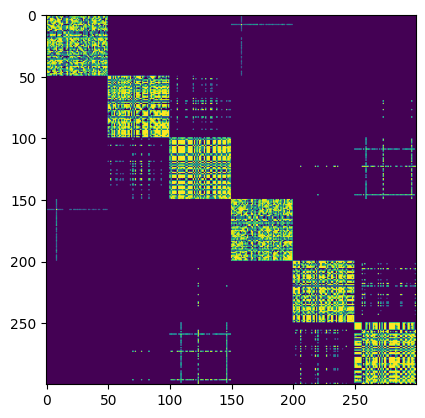

Edges wont be set with similarity measure above: 0.9490769533826342
<><><><><><><><><><><><>    Starting Epoch 0    <><><><><><><><><><><><><>
Total number of Known_connections: 13234
New connections found: 30


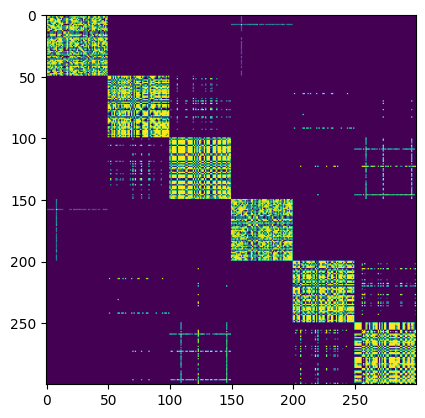

Using optimal t value of 37
The new connections worsened the alignment by 0.024166666666666656
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 1    <><><><><><><><><><><><><>
Total number of Known_connections: 13234
New connections found: 30


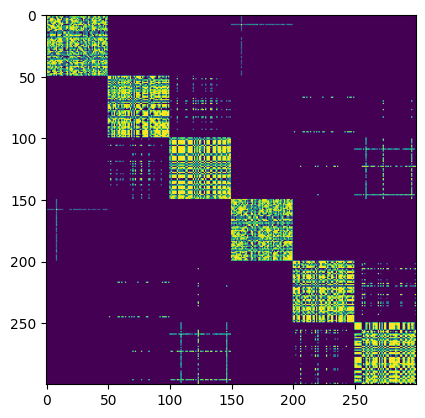

Using optimal t value of 37
The new connections worsened the alignment by 0.012499999999999983
-----------     Pruning the new connections. Continuing...    -----------

<><><><><><><><><><><><>    Starting Epoch 2    <><><><><><><><><><><><><>
Total number of Known_connections: 13234
New connections found: 30


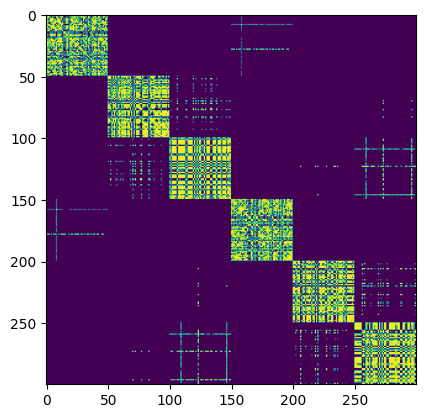

Using optimal t value of 37
The new connections worsened the alignment by 0.005833333333333315
-----------     Pruning the new connections. Continuing...    -----------

Using optimal t value of 22
Added Hold Out Anchor Conections


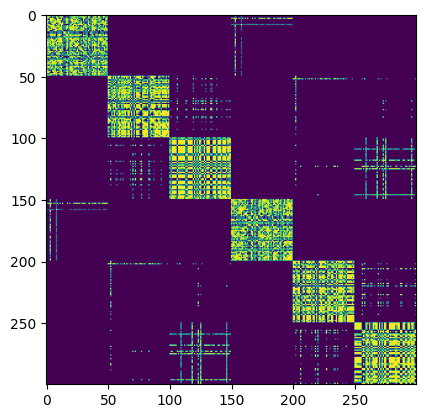

<><><><><><><><><><<><><><><<> Epochs Finished <><><><><><><><><><><><><><><><><>


False

In [20]:
mash_class.optimize_by_creating_connections(epochs=3, connection_limit= 30, threshold = 0.9, hold_out_anchors=dc.anchors[4:8])

Cross Embedding: 0.98
FOSCTTM: 0.1311111111111111


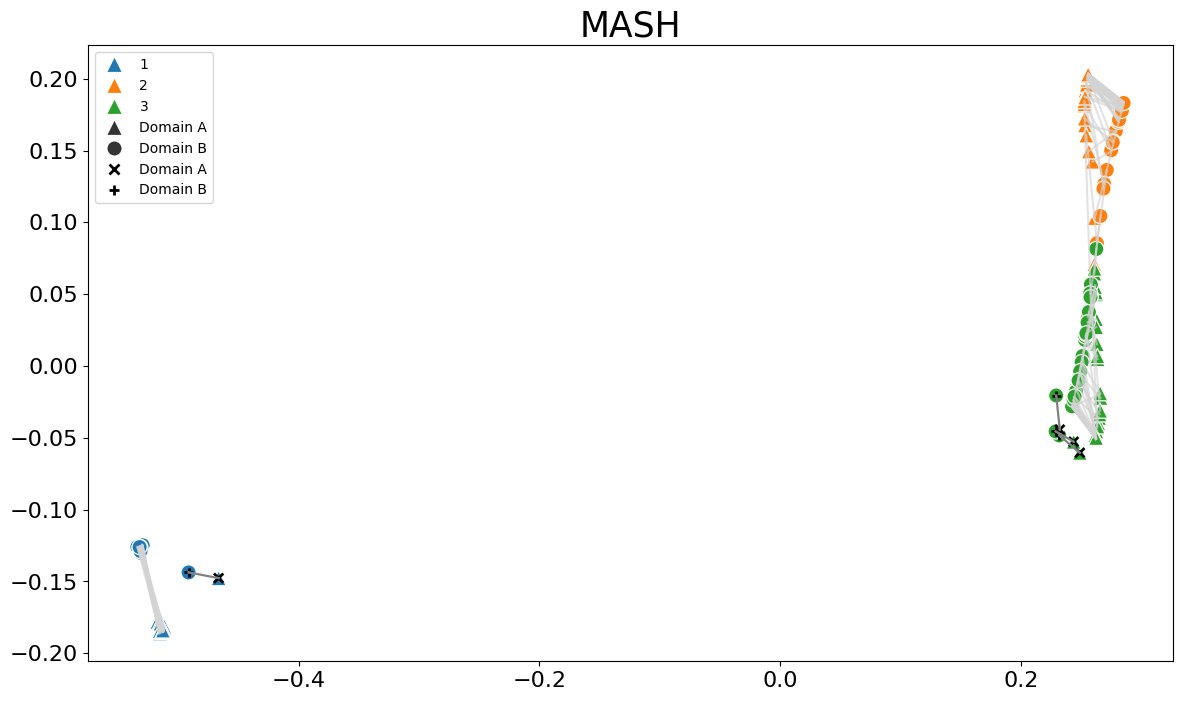

In [21]:
mash_class.plot_emb(labels = dc.labels_doubled)